# Analyzing My Netflix Activity with Python
*by Daria Yuferova*


## Project Description

Just recently (after everyone else apparently) I found out that you can request the personal profile information from Netflix. Of course I had to try it for myself and play with analyzing my profile's data!  
You can do the same following the Netflix instructions on [the official website](https://www.netflix.com/account/getmyinfo). 

This report will cover the process of my analysis, including cleaning and transforming data, analyzing it, and visualizing some insights from content viewing data.

## STEP 1. Collecting Data

First of all, we need to import all the necessary packages:

In [1]:
import pandas as pd # to manipulate dataframes
import numpy as np # to manipulate numeric arrays
from datetime import timedelta # to handle datetime values
from pandas.api.types import CategoricalDtype # to custom sort certain values
import matplotlib.pyplot as plt # to visualize the results
import seaborn as sns # to visualize them even better

Inside the data package sent by Netflix the most interesting table is called ViewingActivity, containing (as you might guess) the information on all views registered in the account since registration, including all profiles under the account.  
Upload the said file:

In [2]:
viewing_activity = pd.read_csv('../data/ViewingActivity.csv')

Let's get a first look at the data:

In [3]:
viewing_activity.head()

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Alexander,2023-07-01 17:42:24,00:00:10,NaN,The Witcher Season 3 Volume 2 Teaser,TEASER_TRAILER,Chrome PC (Cadmium),00:00:10,00:00:10,US (United States)
1,Alexander,2023-07-01 16:56:38,00:45:45,NaN,The Witcher: Season 3: The Art of the Illusion...,NaN,Chrome PC (Cadmium),00:45:52,00:45:52,US (United States)
2,Alexander,2023-07-01 16:06:13,00:50:04,NaN,The Witcher: Season 3: The Invitation (Episode 4),NaN,Chrome PC (Cadmium),00:50:13,00:50:13,US (United States)
3,Alexander,2023-07-01 07:57:55,00:00:02,Autoplayed: user action: None;,The Witcher: Season 3: The Invitation (Episode 4),NaN,Chrome PC (Cadmium),00:00:08,Not latest view,US (United States)
4,Alexander,2023-07-01 06:56:22,00:56:08,NaN,The Witcher: Season 3: Reunion (Episode 3),NaN,Chrome PC (Cadmium),00:56:14,00:56:14,US (United States)


In [4]:
viewing_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Profile Name             2655 non-null   object
 1   Start Time               2655 non-null   object
 2   Duration                 2655 non-null   object
 3   Attributes               1135 non-null   object
 4   Title                    2655 non-null   object
 5   Supplemental Video Type  808 non-null    object
 6   Device Type              2655 non-null   object
 7   Bookmark                 2655 non-null   object
 8   Latest Bookmark          2655 non-null   object
 9   Country                  2655 non-null   object
dtypes: object(10)
memory usage: 207.5+ KB


We can see that the table contains 10 columns and 2655 rows with data on the viewer, duration, device used, title, etc.  
Let's check the columns that are unclear for us:

In [5]:
viewing_activity['Attributes'].value_counts()

Autoplayed: user action: None;                 872
Autoplayed: user action: User_Interaction;     254
Has branched playback;                           8
Autoplayed: user action: Unspecified;            1
Name: Attributes, dtype: int64

Let's leave this column in for now, it might be interesting to investigate autoplay efficiency.  
From the additional documents provided by Netflix we know:  
"Autoplayed: user action: None" - means that the viewer did not interact with that TV show or movie.  
"Autoplayed: user action: User_Interaction" - means that the viewer interacted with the TV show or movie in a browser, by clicking on the video player controls or using keyboard shortcuts.  
"Has branched playback" - means that the viewer can make choices during playback, to control what happens next. In this particular case we will need to delete those rows from the analysis as we can't consider it a show or a movie (Triviaverse).

In [6]:
viewing_activity['Device Type'].value_counts()

MStar Pure Turnkey Skyworth OEM4K Smart TV      1572
Chrome PC (Cadmium)                              771
Safari MAC (Cadmium)                             217
Android DefaultWidevineL3Phone Android Phone      88
DefaultWidevineAndroidPhone                        7
Name: Device Type, dtype: int64

Let's leave this column in, it might be interesting to analyze what devices we use for Netflix.

In [7]:
viewing_activity['Supplemental Video Type'].value_counts()

HOOK              530
TRAILER           213
TEASER_TRAILER     55
RECAP              10
Name: Supplemental Video Type, dtype: int64

Let's remove this column as we are interested in movies and shows, not trailers or teasers.

In [8]:
viewing_activity['Country'].value_counts()

CY (Cyprus)            2382
US (United States)      143
TR (Turkey)              89
AM (Armenia)             21
ZA (South Africa)        12
GB (United Kingdom)       5
SG (Singapore)            1
RS (Serbia)               1
GE (Georgia)              1
Name: Country, dtype: int64

This column could've been interesting but in our case it only shows that some of the account users (ahem, my brother) utilize VPN servers. We will remove this column from our analysis.

## STEP 2. Cleaning and Preparing Data for Analysis

Now that we have familiarized ourselves with the data, we can start cleaning it for our needs.  
First, delete unnecessary columns and rows leaving only the information regarding tv shows and movies, rename them:

In [9]:
viewing_activity = viewing_activity.drop(list(viewing_activity)[7:10], axis=1)
viewing_activity = viewing_activity.rename(columns={"Profile Name": "profile_name", "Start Time": "start_time",
                                                    "Duration": "duration", "Attributes": "autoplay",
                                                    "Title": "full_title", 
                                                    "Supplemental Video Type": "supp_vid_type",
                                                    "Device Type": "device_type"})

# Clean all the trailers/teasers from supp_vid_type column:
viewing_activity = viewing_activity[viewing_activity.supp_vid_type.isna()] \
    .drop(columns='supp_vid_type') \
    .reset_index(drop=True)

# Clean data based on autoplay column:
viewing_activity = viewing_activity[viewing_activity.autoplay != 'Has branched playback; ']

Let's check dataframe for duplicates and NAs:

In [10]:
duplicateRows = viewing_activity[viewing_activity.duplicated()]
duplicateRows # no full duplicates

,profile_name,start_time,duration,autoplay,full_title,device_type


In [11]:
print(viewing_activity.isnull().values.sum()) # 1495 NAs
print(viewing_activity.isnull().values.sum()==len(viewing_activity[viewing_activity.autoplay.isna()]))
# all the NAs account for autoplay column (where no autoplay option was used)

1495
True


This looks good enough for us!  
Now check the users attached to the Netflix profile and their activity:

In [12]:
viewing_activity['profile_name'].value_counts()

Daria        1633
Alexander     123
Дом            83
Name: profile_name, dtype: int64

Daria is me (I use my profile together with my boyfriend), Alexander is my brother (who we know is a big travel lover 😉), Дом is my parents profile.  
Let's delete the last one as it contains information in Cyrillic which would be harder to interpret and is of insignificant number (83 records out of 1847):

In [13]:
viewing_activity = viewing_activity.drop(viewing_activity[viewing_activity.profile_name == 'Дом'].index)

Continue cleaning up the dataset and transforming a rather complex `full_title` column into digestible parts. We need the title itself, season, episode extracted from the original column.  
We will also add a new column with the type of content viewed: Movie, Series or Limited Series (when `full_title` contains episodes but not seasons).

In [14]:
# Rearrange columns so that the device type would be between autoplay and title columns:
viewing_activity.insert(4, 'device_type', viewing_activity.pop('device_type'))

# Fill the title, season, episode columns:
viewing_activity['title'] = viewing_activity['full_title']. \
    apply(lambda x: x.split(': ')[0] if 'Episode' in x else x)
viewing_activity['season'] = viewing_activity['full_title']. \
    apply(lambda x: x.split('Season ')[1] if 'Episode' in x and 'Season' in x 
          else 'Limited Series' if 'Episode' in x 
          else 'Movie')
viewing_activity['episode'] = viewing_activity['full_title']. \
    apply(lambda x: x.split(' ')[-1] if 'Episode' in x else 'Movie')

# Clean up episode and season columns:
viewing_activity['episode'] = viewing_activity['episode'] \
    .str.replace(')', '', regex=False) \
    .str.replace('One', '1', regex=False)
viewing_activity['season'] = viewing_activity['season'].apply(lambda x: x.split(': ')[0] if ': ' in x else x)

# Add information on movie/series/limited series type of content:
viewing_activity['content_type'] = viewing_activity['season']. \
    apply(lambda x: 'Movie' if x == 'Movie' 
          else 'Limited Series' if x == 'Limited Series' 
          else 'Series')

Now let's move on to transforming `start_time` and `duration` columns. We need to set up datetime data type, extract necessary info, and account for timezone difference:

In [15]:
# Change the type of start_time column to datetime:
viewing_activity['start_time'] = pd.to_datetime(viewing_activity['start_time'])

# Extract month of viewing:
viewing_activity.insert(5, 'month_of_start', viewing_activity['start_time'].dt.strftime('%b'))

# We need to change time records by profile user (Daria - GMT+2/GMT+3 (summertime), Alexander - GMT+3), 
# considering Netflix stores data in GMT timezone format:
viewing_activity.insert(2, 'user_start_time', viewing_activity['start_time'] + timedelta(hours=3))
# Create a mask to filter rows that we need to edit:
m = (viewing_activity['profile_name'] == 'Daria') & \
    (viewing_activity['month_of_start'].isin(['Nov', 'Dec', 'Jan', 'Feb', 'Mar']))
viewing_activity.loc[m, 'user_start_time'] = \
    viewing_activity['start_time'] + timedelta(hours=2)

# Extract hour and day of week of viewing:
viewing_activity.insert(3, 'time_of_start', viewing_activity['user_start_time'].dt.strftime('%H'))
viewing_activity['time_of_start'] = pd.to_numeric(viewing_activity['time_of_start'])
viewing_activity.insert(4, 'day_of_week_start', viewing_activity['user_start_time'].dt.strftime('%a'))

# Change duration column datatype to integer:
viewing_activity.insert(7, 'duration_in_mins',
                        pd.to_numeric((pd.to_timedelta(viewing_activity['duration']).dt.total_seconds() / 60))
                        .astype('int64'))

# Check if the values are appropriate and consistent with what we're expecting:
print(viewing_activity['start_time'].min(), viewing_activity['start_time'].max())
print(viewing_activity['duration_in_mins'].min(), viewing_activity['duration_in_mins'].max())

2022-06-03 17:08:20 2023-07-01 16:56:38
0 174


Here we can see that our dataset has viewing data spanning just under a year (corresponding with when we switched Netflix accounts) and ranging from 0 to almost 3 hours (which again looks fine).  
Let's run another test on data consistency by checking if one title matches only one type of content:

In [16]:
consistent_type = viewing_activity[['title', 'content_type']] \
    .groupby('title', observed=True) \
    .nunique('content_type') \
    .reset_index()
consistent_type = consistent_type[consistent_type.content_type != 1]

print(consistent_type)

               title  content_type
64     Gilmore Girls             2
127  Stranger Things             2


In [17]:
# Gilmore Girls do indeed have both Series with several seasons and a Limited Series afterwards
# but Stranger Things looks like a mistake. Clean all the rows with title 'Stranger Things':

# Create a mask to filter rows that we need to edit:
m = (viewing_activity['title'] == 'Stranger Things') & (viewing_activity['content_type'] == 'Limited Series')

viewing_activity.loc[m, 'season'] = '4'
viewing_activity.loc[viewing_activity.title == 'Stranger Things', 'content_type'] = 'Series'

Now let's see how efficient the autoplay feature is for us.
Let's calculate the percentage of successful (over 1 minute) autoplay views with/without additional user interaction:

In [18]:
pd.options.mode.chained_assignment = None  # to deal with false positive warnings raising here

autoplay_df = viewing_activity[['autoplay', 'duration_in_mins']]
autoplay_df['success'] = autoplay_df['duration_in_mins'].apply(lambda x: '> 1 min' if x > 1 else '<= 1 min')
autoplay_df = autoplay_df.drop(columns='duration_in_mins') \
    .groupby('autoplay')['success'].value_counts()
print(autoplay_df)

autoplay                                     success 
Autoplayed: user action: None;               <= 1 min     86
                                             > 1 min       4
Autoplayed: user action: User_Interaction;   > 1 min     240
                                             <= 1 min     14
Name: success, dtype: int64


We see that over 95% of autoplay with no user interaction (where we don't press any buttons) doesn't work: we end up not watching those episodes/movies. On the contrary, in the case of autoplay with user confirmation we have 94% of successful views.  
Interesting to know that we strongly prefer to consent to autoplay and be proactive with it!  

After this inspection, let's remove all entries of less than 1 minute from the dataset and clean up unnecessary columns:

In [19]:
viewing_activity_clean = viewing_activity[viewing_activity.duration_in_mins > 1]

viewing_activity_clean = viewing_activity_clean.drop(columns=['autoplay', 'start_time', 'duration'])

Check again for duplicates and NAs after all the modifications:

In [20]:
print(viewing_activity_clean.isnull().values.sum()) # no NAs

0


In [ ]:
duplicateRows_clean = viewing_activity_clean[viewing_activity_clean.duplicated()].reset_index()
print(duplicateRows_clean) # we have some full duplicates

In [ ]:
# Check for partial duplicates based on full title:
duplicateRows_duration = viewing_activity_clean[viewing_activity_clean[['duration_in_mins', 'full_title']] \
                                                .duplicated()] \
                                                .reset_index()
duplicateRows_time = viewing_activity_clean[viewing_activity_clean[['user_start_time', 'full_title']] \
                                                .duplicated()] \
                                                .reset_index()
print(duplicateRows_duration, duplicateRows_time) # we have some partial duplicates

In [23]:
# Remove all the duplicates:
duplicates = pd.merge(duplicateRows_clean, duplicateRows_duration, how='outer')
duplicates = pd.merge(duplicates, duplicateRows_time, how='outer').set_index('index')

viewing_activity_clean = viewing_activity_clean.drop(index=duplicates.index, axis=0).reset_index(drop=True)

We are ready for the analysis!

## STEP 3. Descriptive Analysis

Let's get general statistics on views/pieces of content:

In [24]:
# The average duration of viewing session per user:
duration_stats = viewing_activity_clean.groupby(['profile_name', 'content_type'])['duration_in_mins'].mean() \
    .reset_index() \
    .rename(columns={'duration_in_mins': 'avg_duration_in_mins'})

duration_stats['avg_duration_in_mins'] = duration_stats['avg_duration_in_mins'].astype('int64')

# The number of pieces of content per user:
views_stats = viewing_activity_clean \
    .groupby(['profile_name', 'content_type']) \
    .full_title.agg(['nunique', 'count']) \
    .reset_index()

views_stats = views_stats.rename(columns={'count': 'N_of_views', 'nunique': 'N_of_distinct_pieces'})
views_stats.insert(2, 'N_of_unique_titles', viewing_activity_clean
                   .groupby(['profile_name', 'content_type'])['title'].nunique().reset_index()['title'])
views_stats['views_per_piece'] = round((views_stats['N_of_views'] / views_stats['N_of_distinct_pieces']), 2)

views_df = pd.merge(duration_stats, views_stats, on=['profile_name', 'content_type'], how='outer')

# Sort the table in order that we need for presenting:
views_df = views_df.sort_values(by=['profile_name','N_of_unique_titles']).set_index('profile_name')
views_df.insert(5, 'avg_duration_in_mins', views_df.pop('avg_duration_in_mins'))

views_df

,content_type,N_of_unique_titles,N_of_distinct_pieces,N_of_views,views_per_piece,avg_duration_in_mins
profile_name,,,,,,
Alexander,Limited Series,1,10,14,1.40,35
Alexander,Series,6,34,43,1.26,38
Alexander,Movie,15,15,23,1.53,67
Daria,Limited Series,12,61,95,1.56,25
Daria,Series,43,763,1068,1.40,24
Daria,Movie,90,90,159,1.77,56


We can conclude that I watch a lot more content on Netflix than my brother, in all categories.  
However, the average view duration in my case is smaller, hence the number of views per piece of content is higher. This means that I watch Netflix more regularly, but my viewings are shorter, so to get through the same movie I need more viewings than my brother, who has fewer but longer Netflix sessions.

## STEP 4. Visualizations

Prepare for visualizations:

In [25]:
# Sort days of the week and months in order that we need for visualizations:
cat_day_of_week = CategoricalDtype(['Mon', 'Tue', 'Wed',
                                    'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
cat_month = CategoricalDtype(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
viewing_activity_clean['day_of_week_start'] = viewing_activity_clean['day_of_week_start'].astype(cat_day_of_week)
viewing_activity_clean['month_of_start'] = viewing_activity_clean['month_of_start'].astype(cat_month)

# Set the overall theme and size for visualizations:
my_palette = ["#f5253a", "#620163", "#ba0066", "#fcb292"]
sns.set_theme(style='whitegrid', palette=my_palette)
plt.rcParams['figure.figsize'] = [8.6, 6.4]

Let's first plot the density distribution of viewings duration by user, to see the patterns better:

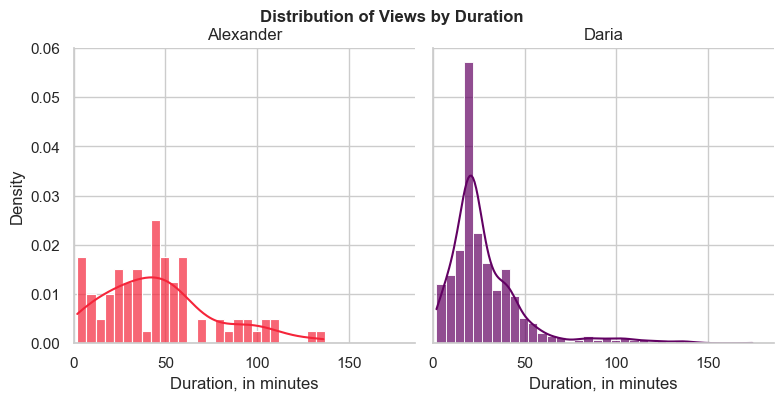

In [26]:
g = sns.FacetGrid(data=viewing_activity_clean, col='profile_name', height=4, 
                  hue='profile_name', palette=my_palette)
g.map_dataframe(sns.histplot, x='duration_in_mins',  binwidth=5, stat='density', kde=True, alpha=0.7)
g.set_axis_labels('Duration, in minutes')
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Distribution of Views by Duration', weight='bold', y=1, fontsize=12)
plt.xlim(0) # to start labels from the very beginning of axis

plt.show()

Again, we can see how my graph peaks at around 25 minutes, contentrated in the area between 0 and 50 minutes.   
Alexander's curve is more flat (more distributed), with maximum at around 50 minutes.

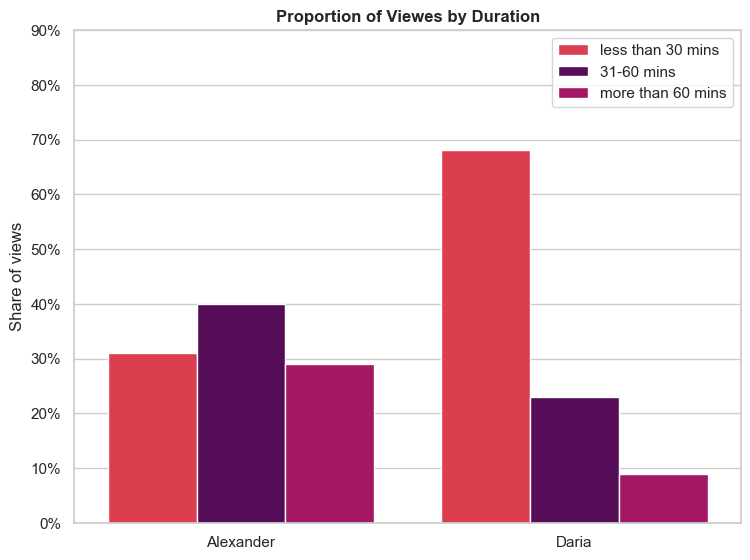

In [27]:
# Let's go a little deeper and present this visualization by duration category:
dur_category = viewing_activity_clean[['profile_name', 'duration_in_mins']]


def categorize_duration(x):
    if x < 30:
        cat = 'less than 30 mins'
    elif 31 < x < 60:
        cat = '31-60 mins'
    else:
        cat = 'more than 60 mins'
    return cat


# Sort categories in order that we need for visualizations:
cat_category = CategoricalDtype(['less than 30 mins', '31-60 mins', 'more than 60 mins'], ordered=True)
dur_category['category'] = dur_category['duration_in_mins'].apply(categorize_duration).astype(cat_category)

dur_category = dur_category.groupby(['profile_name', 'category']) \
    .category.agg(['count']) \
    .reset_index() \
    .rename(columns=({'count': 'number_of_cases'}))
dur_category['sum_per_user'] = dur_category.groupby('profile_name') \
    .number_of_cases.transform('sum')
dur_category['share_of_category'] = round(dur_category['number_of_cases'] / dur_category['sum_per_user'], 2)

fig, ax = plt.subplots()

sns.barplot(data=dur_category, x='profile_name', y='share_of_category', hue='category') \
    .set(xlabel='',
         ylabel='Share of views')
ax.set_title('Proportion of Viewes by Duration', fontweight='bold')
ax.legend(title='')
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])  # show y axis with percentages

plt.show()

This graph confirmed our conclusions: my viewing sessions mostly last under 30 minutes.  

Plot the distribution of length of shows watched by users:

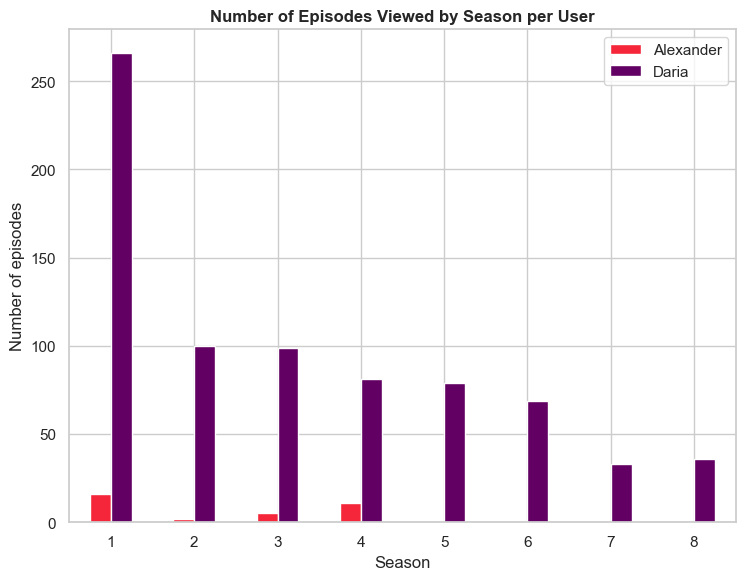

In [28]:
# We need to filter only Series content_type, count unique episode titles by groups and pivot dataframe to plot:
ax = viewing_activity_clean \
    .drop(viewing_activity_clean[(viewing_activity_clean['season']=='Movie') | 
                                 (viewing_activity_clean['season']=='Limited Series')].index) \
    .groupby(['season', 'profile_name'])['full_title'].nunique() \
    .unstack().plot(kind='bar')
ax.set(xlabel='Season', ylabel='Number of episodes')
ax.set_title('Number of Episodes Viewed by Season per User', weight='bold')
ax.legend(title='')
ax.tick_params(axis='x', rotation=0)

plt.show()

My brother doesn't seem to watch series longer that 4 seasons, interesting. Because - what about The Office ?!

Now let's take a closer look at user behaviour: how exactly do we watch our shows?

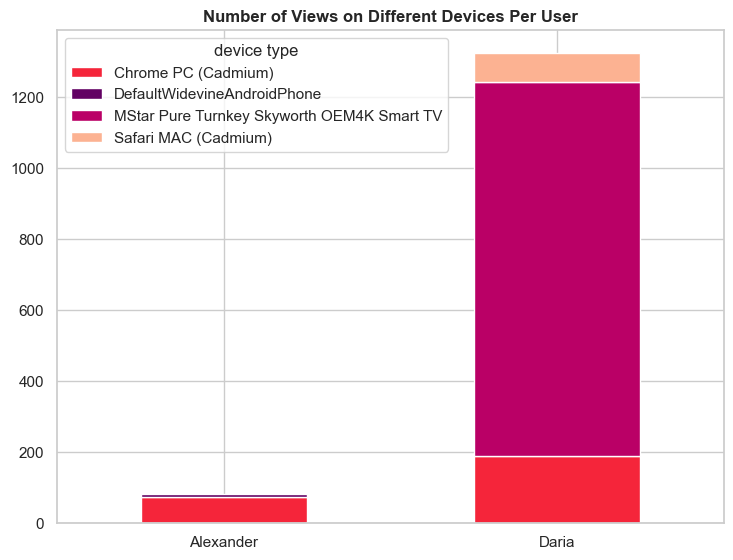

In [29]:
# Plot what devices we use:
ax = viewing_activity_clean.groupby(['profile_name', 'device_type']).size() \
            .unstack().plot(kind='bar', stacked=True)
ax.set_title('Number of Views on Different Devices Per User', fontweight='bold')
ax.set(xlabel='')
ax.legend(title='device type', loc='upper left')
ax.tick_params(axis='x', rotation=0)

plt.show()

My brother mostly uses his web browser and a tiny proportion of his viewings account for his phone. Me and my boyfriend use our TV most of the time, then my or my boyfriend's laptop browsers. Here we once again see the noticeable gap between my and my brother's account activity 🤦‍.

After that I wanted to make histograms with my and Alexander's number of views from different angles. However, due to the significant difference between our viewings, his numbers were barely noticeable.  
So we'll use FacetGrid again to clearly show our data side by side:

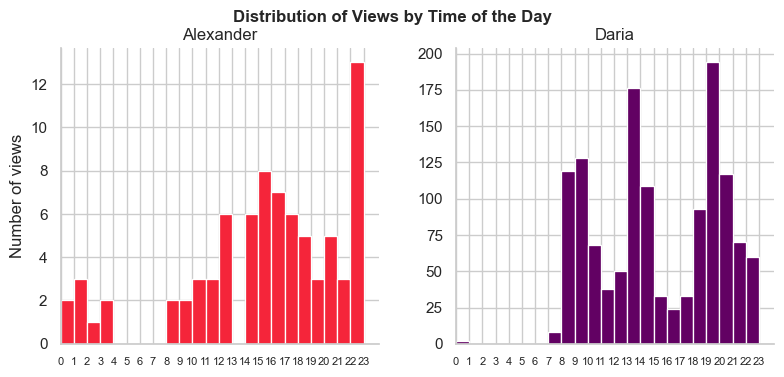

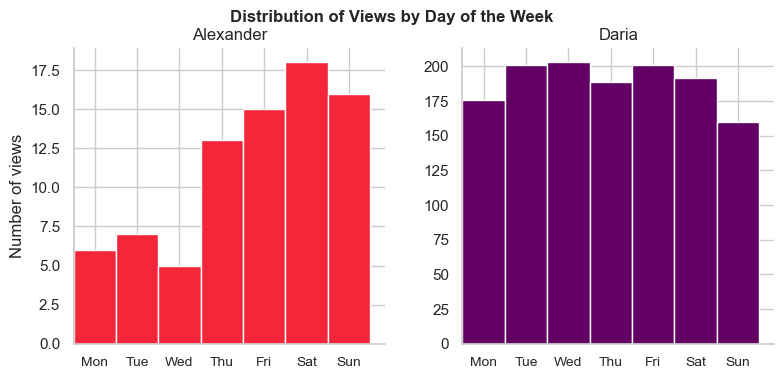

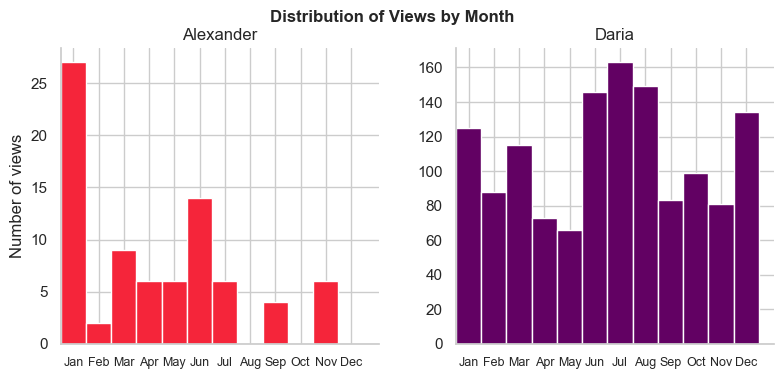

In [30]:
# Plot the number of views by user
# by hour:
h = sns.FacetGrid(data=viewing_activity_clean, col='profile_name', height=4, 
                  hue='profile_name', palette=my_palette, sharey=False)
h.map_dataframe(sns.histplot, x='time_of_start',  binwidth=1, stat='count', alpha=1)
h.set_axis_labels('','Number of views')
h.set(xticks=np.arange(0,24,1))
h.set_xticklabels(fontsize=8) # to fit all the labels
h.set_titles(col_template='{col_name}')
h.fig.suptitle('Distribution of Views by Time of the Day', weight='bold', y=1, fontsize=12)
plt.xlim(0) # to start labels from the very beginning of axis

# by day of the week:
d = sns.FacetGrid(data=viewing_activity_clean, col='profile_name', height=4, 
                  hue='profile_name', palette=my_palette, sharey=False)
d.map_dataframe(sns.histplot, x='day_of_week_start',  binwidth=1, stat='count', alpha=1)
d.set_axis_labels('', 'Number of views')
d.set_xticklabels(fontsize=10)
d.set_titles(col_template='{col_name}')
d.fig.suptitle('Distribution of Views by Day of the Week', weight='bold', y=1, fontsize=12)
plt.xlim(-0.5) # to start labels from the very beginning of axis

# by month:
m = sns.FacetGrid(data=viewing_activity_clean, col='profile_name', height=4, 
                  hue='profile_name', palette=my_palette, sharey=False)
m.map_dataframe(sns.histplot, x='month_of_start',  binwidth=1, stat='count', alpha=1)
m.set_axis_labels('', 'Number of views')
m.set_xticklabels(fontsize=9)
m.set_titles(col_template='{col_name}')
m.fig.suptitle('Distribution of Views by Month', weight='bold', y=1, fontsize=12)
plt.xlim(-0.5) # to start labels from the very beginning of axis

plt.show()

My brother, unlike us, watched Netflix a couple of times at night, and most of his viewings concentrate in the evening. He is also more active towards weekends, which makes sense since he has to go to the offcie on weekdays. Regarding monthly activity - he was inactive in August, October and December (unclear why), with number of views peaking in January and June (which might be connected to some big Netflix premieres or Alexander's vacations).  
On our end the daily trend can clearly be seen - we watch Netflix together while eating (I know I know, it's not heathly but alas), because we work from home: the number peaks at 9h, 13h and 19h. For the same reason we are active at about the same level during the whole week (little less on Sundays-fundays). Interestingly, Autumn and Spring are not Netflix seasons for us!
  
Let's practise another way to visualize viewing patterns - a heatmap:

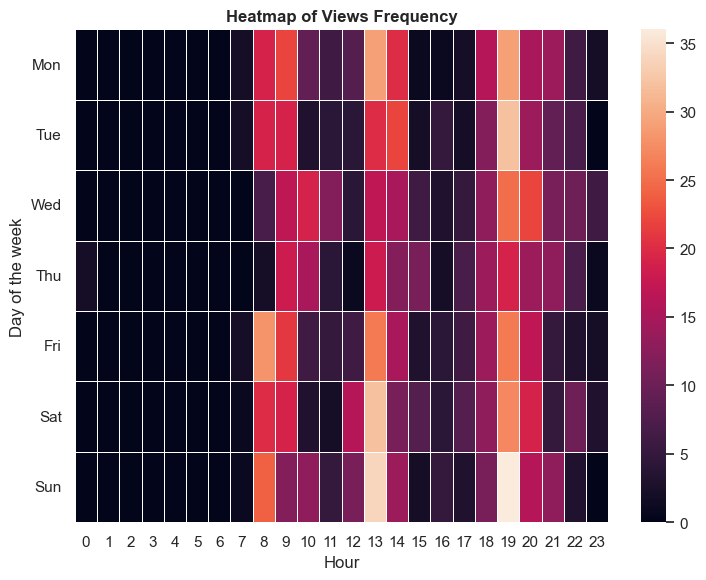

In [35]:
# Plot views per day/hour in a heatmap for my profile:

df = viewing_activity_clean[viewing_activity_clean.profile_name == 'Daria']

# round up the timestamps to remove minutes and seconds:
df['user_start_time'] = df['user_start_time'].apply(lambda x: x.strftime("%Y-%m-%d, %H:00:00"))

# create a dataframe with date+hour and number of views at that time:
by_hour = df['user_start_time'].value_counts().sort_index(ascending=True) 
by_hour.index = pd.to_datetime(by_hour.index)

# fill in the missing date+hour with 0 views:
idx = pd.date_range(min(by_hour.index), max(by_hour.index), freq='1H')
df_count = by_hour.reindex(idx, fill_value=0)

df_count = df_count.rename_axis('datetime').reset_index(name='freq')
df_count['hour'] = df_count['datetime'].dt.hour
df_count['day'] = df_count['datetime'].dt.strftime('%a')
df_count = df_count.drop(['datetime'], axis=1)

# groupby and pivot dataframe for plotting:
df_heatmap = df_count[['day', 'hour', 'freq']].groupby(['day', 'hour']).sum().unstack()

# create lists of values for axes labels:
hours_list = list(range(0, 24))
days_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = sns.heatmap(df_heatmap, linewidth=0.5, yticklabels=days_list, xticklabels=hours_list)
ax.set(xlabel='Hour', ylabel='Day of the week')
ax.set_title('Heatmap of Views Frequency', fontweight='bold')
ax.tick_params(axis='both', rotation=0)

plt.show()

Here again we can see our breakfast-lunch-dinner peaks of viewing activity. Additionally here we can see that Sunday 7pm dinner time is the most popular time for us to start watching Netlfix.

Let's also check if there is a pattern of binge-watching - only for Series within one season and Limited Series.  
By binge-watching here we understand the entry where time of the beginning of the next episode is within 5 minutes from finishing the previous one:

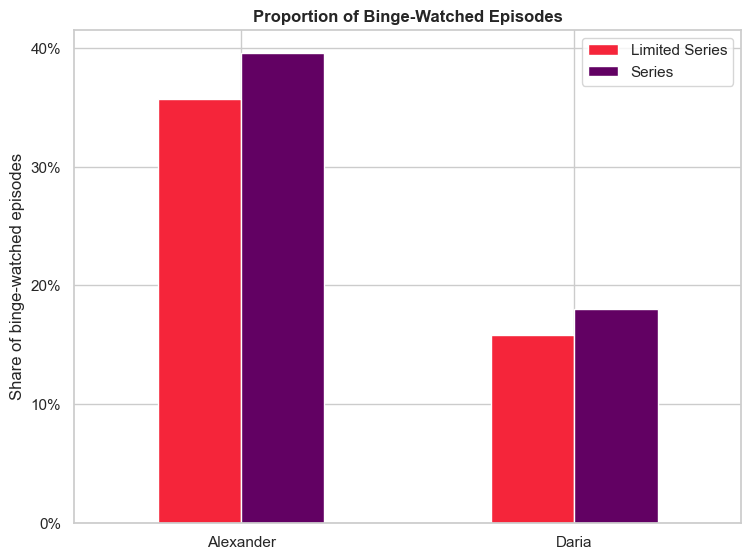

In [32]:
# get only the data we need:
binge_df = viewing_activity_clean.loc[viewing_activity_clean.content_type != 'Movie'].reset_index(drop=True)

# change the datatype of episode column:
binge_df['episode'] = binge_df['episode'].astype('int64')

# create lags for one view forward:
binge_df['next_start_time'] = binge_df \
    .groupby(['profile_name', 'title'])['user_start_time'].shift(1)
binge_df['next_episode'] = binge_df \
    .groupby(['profile_name', 'title'])['episode'].shift(1)
binge_df['next_season'] = binge_df \
    .groupby(['profile_name', 'title'])['season'].shift(1)


# create function to iterate through rows to get the ending time:
def get_end_time(row):
    return row['user_start_time'] + timedelta(minutes=row['duration_in_mins'])


# create function to iterate through rows to find binge-watching entries:
def is_binge(row):
    if (row['next_start_time'] <= row['end_time'] + timedelta(minutes=5)) \
    & (row['next_episode'] == row['episode'] + 1) \
    & (row['next_season'] == row['season']):
        return 1
    else:
        return 0


binge_df['end_time'] = binge_df.apply(get_end_time, axis=1)
binge_df['binge'] = binge_df.apply(is_binge, axis=1)
binge_df['share_of_binge'] = binge_df.groupby(['profile_name', 'content_type'])['binge'].transform('sum') / \
                             binge_df.groupby(['profile_name', 'content_type'])['binge'].transform('count')
binge_df = binge_df.reset_index(drop=True)

# Plot the share of binge-watched episodes per user:
ax = binge_df.groupby(['profile_name', 'content_type'])['share_of_binge'].mean().unstack().plot(kind='bar')
ax.set(xlabel='', ylabel='Share of binge-watched episodes')
ax.set_title('Proportion of Binge-Watched Episodes', fontweight='bold')
ax.legend(title='', loc='upper right')
ax.tick_params(axis='x', rotation=0)
ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])  # show y axis with percentages

plt.show()

Interestingly, despite having fewer episodes viewed, my brother has twice the share of binge-watched episodes than me. Every third episode he watches is definitely followed by the next one within 5 minutes.  

Let's check if there is a connection between binge-watching and time of the day/of the week:

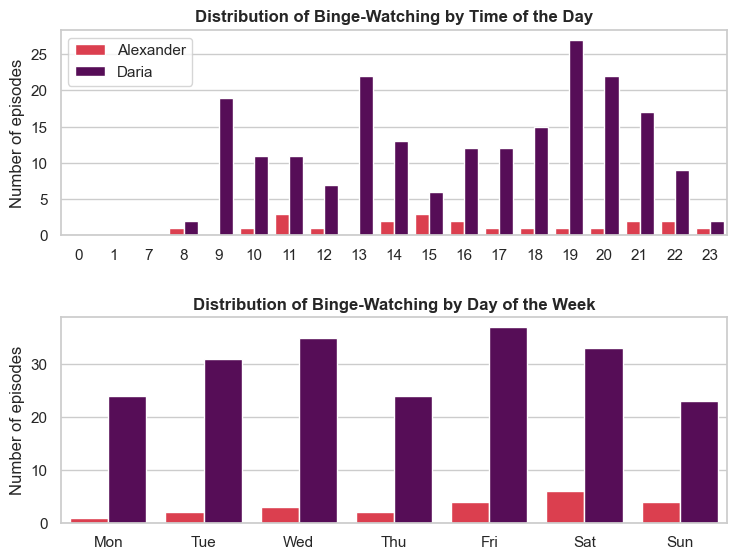

In [33]:
# Plot the number of binge-watched episodes by user by time/day of the week:
fig, ax = plt.subplots(2, 1)

sns.barplot(data=binge_df, x='time_of_start', y='binge', hue='profile_name',
            estimator='sum', errorbar=None, ax=ax[0]) \
    .set(xlabel='',
         ylabel='Number of episodes')
ax[0].set_title('Distribution of Binge-Watching by Time of the Day', fontweight='bold')
ax[0].legend(title='', loc='upper left')

sns.barplot(data=binge_df, x='day_of_week_start', y='binge', hue='profile_name',
            estimator='sum', errorbar=None, ax=ax[1]) \
    .set(xlabel='',
         ylabel='Number of episodes')
ax[1].set_title('Distribution of Binge-Watching by Day of the Week', fontweight='bold')
ax[1].get_legend().remove()

plt.subplots_adjust(hspace=0.4)  # adjusting spacing between the subplots

plt.show()

My brother obviously has fewer binge-watched episodes, in absolute terms. But he tends to watch them on the weekends a little bit more. I have a tendency to binge-watch in the evening, with the maximum of 37 episodes watched on Fridays over the last year.

## Conclusion

I really enjoyed dealing with the personal data for analysis. I found some insights about my own behaviour as a content viewer, and visualized trends using various Matplotlib and Seaborn instruments.  
There are several ways to take this research further: to include some of the removed columns into analysis, or to dive deeper into genres/distinct shows and titles/most watched episodes (props to The Office and The Friends, ofc) etc.
However, I feel we lack data - several years of data from multiple users would be preferable to compare and contrast.  
So, I advice you to do the same exercise with your data if you feel like it - it was fun and educational for me.
  
*The End. Now on to the never-ending circle of me providing Netflix with more viewing data for future me to analyze! :)*